In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from priority_tools import get_insol_flux, ars_from_t, k_amp_finder
pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

In [2]:
# These are systems that are on exoplanet archive, but don't have a J mag or K mag from the confirmed 
# or composite tables
sim_df = pd.DataFrame(data={
    'fpl_hostname':['HD 202772 A',
'OGLE-TR-056',
'OGLE-TR-10',
'OGLE-TR-111',
'OGLE-TR-113',
'OGLE-TR-132',
'SWEEPS-11',
'WASP-105',
'WASP-161',
'WASP-163',
'WASP-170',
'WASP-190',
'WASP-91'],
    'j_mag':[np.nan,
np.nan,
np.nan,
14.7,
np.nan,
np.nan,
np.nan,
10.456,
10.09,
10.673,
11.133,
10.859,       
10.28]
})
# sim_df.to_csv('../data/known_planets/simbad_jmag.csv', index=False)

In [34]:
# These are systems that are on exoplanet archive, but don't have a J mag or K mag from the confirmed 
# or composite tables
missing_info_df = pd.DataFrame(data={
    'fpl_name':[
        'Kepler-60 a',
        'Kepler-60 b',
        'Kepler-60 c',
        'WASP-157 b',
        'WASP-85 A b',
    ],
    'fst_mass':[
        1.041,
        1.041,
        1.041,
        1.06,
        1.09
    ],
    'fst_rad':[
        1.257,
        1.257,
        1.257,
        1.10,
        0.935,
    ],
    'fst_teff':[
        5905,
        5905,
        5905,
        5772,
        6112
    ],
    'fpl_bmasse':[
        4.19,
        3.85,
        4.16,
        182,
        402.1
    ]
})
# missing_info_df.to_csv('../data/known_planets/missing_info.csv', index=False)

In [2]:
composite_df = pd.read_csv('../data/known_planets/composite.csv', comment='#')
confirmed_df = pd.read_csv('../data/known_planets/confirmed_jmag.csv', comment='#')
simbad_jmag_df = pd.read_csv('../data/known_planets/simbad_jmag.csv')

In [3]:
matched_df = composite_df.merge(confirmed_df, how='left', left_on='fpl_name', right_on='pl_name')

In [4]:
inds = matched_df.index[np.logical_and(pd.isnull(matched_df['st_j']), pd.isnull(matched_df['fst_nirmag']))]
print(matched_df.iloc[inds]['fpl_hostname'])
len(inds)
# np.savetxt('../data/known_planets/no_j_mag_and_no_k_mag_stars.txt', 
#            matched_df.iloc[inds]['fpl_hostname'].values, 
#            fmt='%s')

181    HD 202772 A
567    OGLE-TR-056
568     OGLE-TR-10
569    OGLE-TR-111
570    OGLE-TR-113
571    OGLE-TR-132
586      SWEEPS-11
614       WASP-105
655       WASP-161
657       WASP-163
664       WASP-170
678       WASP-190
755        WASP-91
Name: fpl_hostname, dtype: object


13

In [5]:
len(matched_df)

773

In [6]:
matched_df['j_mag'] = matched_df['st_j'].copy()
matched_simbad_df = matched_df.merge(simbad_jmag_df, 
                                     how='left', 
                                     left_on=['fpl_hostname'], 
                                     right_on=['fpl_hostname'])

In [7]:
len(matched_simbad_df)

773

In [8]:
matched_simbad_df.iloc[755]

fpl_hostname         WASP-91
fpl_letter                 b
fpl_name           WASP-91 b
fpl_discmethod       Transit
fpl_controvflag            0
                     ...    
st_j                     NaN
st_jerr                  NaN
st_jlim                  NaN
j_mag_x                  NaN
j_mag_y                10.28
Name: 755, Length: 112, dtype: object

In [9]:
matched_simbad_df['j_mag'] = matched_simbad_df['j_mag_x'].fillna(matched_simbad_df['j_mag_y'])

In [10]:
matched_simbad_df = matched_simbad_df.drop(columns=['j_mag_x', 'j_mag_y'], axis=1)

In [11]:
matched_simbad_df.iloc[181]

fpl_hostname         HD 202772 A
fpl_letter                     b
fpl_name           HD 202772 A b
fpl_discmethod           Transit
fpl_controvflag                0
                       ...      
pl_name            HD 202772 A b
st_j                         NaN
st_jerr                      NaN
st_jlim                      NaN
j_mag                        NaN
Name: 181, Length: 111, dtype: object

In [12]:
len(matched_simbad_df)

773

In [13]:
matched_simbad_clean_df = matched_simbad_df.drop(index=matched_simbad_df.index[pd.isnull(matched_simbad_df['j_mag'])]).reset_index(drop=True)

In [14]:
len(matched_simbad_clean_df)

767

In [15]:
len(matched_simbad_clean_df.index[pd.isnull(matched_simbad_clean_df['fpl_insol'])])

399

In [40]:
kp_df = matched_simbad_clean_df.copy()
print(len(kp_df))
print(len(kp_df.index[pd.isnull(kp_df['fpl_insol'])]))

767
399


In [42]:
print(len(kp_df.index[pd.isnull(kp_df['fst_mass'])]))

5


In [43]:
kp_df = kp_df.merge(missing_info_df, how='left', left_on='fpl_name', right_on='fpl_name')
print(len(kp_df))

767


In [45]:
# Fill in the missing information
kp_df['fst_mass'] = kp_df['fst_mass_x'].fillna(kp_df['fst_mass_y'])
kp_df = kp_df.drop(columns=['fst_mass_x', 'fst_mass_y'], axis=1)

kp_df['fst_rad'] = kp_df['fst_rad_x'].fillna(kp_df['fst_rad_y'])
kp_df = kp_df.drop(columns=['fst_rad_x', 'fst_rad_y'], axis=1)

kp_df['fst_teff'] = kp_df['fst_teff_x'].fillna(kp_df['fst_teff_y'])
kp_df = kp_df.drop(columns=['fst_teff_x', 'fst_teff_y'], axis=1)

kp_df['fpl_bmasse'] = kp_df['fpl_bmasse_x'].fillna(kp_df['fpl_bmasse_y'])
kp_df = kp_df.drop(columns=['fpl_bmasse_x', 'fpl_bmasse_y'], axis=1)

In [52]:
bad_ind = kp_df.index[pd.isnull(kp_df['fpl_bmasse'])]
kp_df.iloc[bad_ind]

,fpl_hostname,fpl_letter,fpl_name,fpl_discmethod,fpl_controvflag,fpl_disc,fpl_orbper,fpl_orbpererr1,fpl_orbpererr2,fpl_orbperlim,fpl_orbperreflink,fpl_smax,fpl_smaxerr1,fpl_smaxerr2,fpl_smaxlim,fpl_smaxreflink,fpl_eccen,fpl_eccenerr1,fpl_eccenerr2,fpl_eccenlim,fpl_eccenreflink,fpl_bmasseerr1,fpl_bmasseerr2,fpl_bmasselim,fpl_bmassprov,fpl_bmassreflink,fpl_rade,fpl_radeerr1,fpl_radeerr2,fpl_radelim,fpl_radreflink,fpl_dens,fpl_denserr1,fpl_denserr2,fpl_denslim,fpl_densreflink,fpl_eqt,fpl_eqterr1,fpl_eqterr2,fpl_eqtlim,fpl_eqtreflink,fpl_insol,fpl_insolerr1,fpl_insolerr2,fpl_insollim,fpl_insolreflink,fpl_tranflag,ra_str,ra,dec_str,...,fst_optmagreflink,fst_nirmag,fst_nirmagerr,fst_nirmaglim,fst_nirmagband,fst_nirmagreflink,fst_spt,fst_sptreflink,fst_tefferr1,fst_tefferr2,fst_tefflim,fst_teffreflink,fst_logg,fst_loggerr1,fst_loggerr2,fst_logglim,fst_loggreflink,fst_lum,fst_lumerr1,fst_lumerr2,fst_lumlim,fst_lumreflink,fst_masserr1,fst_masserr2,fst_masslim,fst_massreflink,fst_raderr1,fst_raderr2,fst_radlim,fst_radreflink,fst_met,fst_meterr1,fst_meterr2,fst_metlim,fst_metratio,fst_metreflink,fst_age,fst_ageerr1,fst_ageerr2,fst_agelim,fst_agereflink,pl_name,st_j,st_jerr,st_jlim,j_mag,fst_mass,fst_rad,fst_teff,fpl_bmasse
501,Kepler-60,d,Kepler-60 d,Transit,0,2012,11.8981,0.0002,-0.0002,0.0,<a refstr=JONTOF_HUTTER_ET_AL__2016 href=https...,0.10548,NaN,NaN,0.0,<a refstr=GO__X17A_DZIEWSKI_ET_AL__2016 href=h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kepler-60 d,12.804,0.023,0.0,12.804,NaN,NaN,NaN,NaN


In [53]:
kp_df = kp_df.drop(index=kp_df.index[pd.isnull(kp_df['fst_mass'])]).reset_index(drop=True)

In [54]:
assert len(kp_df.index[pd.isnull(kp_df['fst_mass'])]) == 0, "Still rows with no stellar mass"
assert len(kp_df.index[pd.isnull(kp_df['fst_rad'])]) == 0, "Still rows with no stellar radius"
assert len(kp_df.index[pd.isnull(kp_df['fst_teff'])]) == 0, "Still rows with no Teff"
assert len(kp_df.index[pd.isnull(kp_df['fpl_bmasse'])]) == 0, "Still rows with no planet mass"

In [55]:
kp_df['Ars'] = ars_from_t(kp_df['fpl_orbper'], kp_df['fst_mass'], kp_df['fst_rad'])
kp_df['K_amp'] = k_amp_finder(kp_df['fst_mass'], kp_df['fst_rad'], kp_df['fpl_bmasse'], kp_df['Ars'])

flux_df = pd.DataFrame(data={'fpl_name':kp_df['fpl_name'].copy(), 
                             'Effective Stellar Flux Value':get_insol_flux(kp_df['Ars'], 
                                                                           kp_df['fst_rad'], 
                                                                           kp_df['fst_teff'])})

# Fill in insolation flux values where missing
kp_df = kp_df.merge(flux_df, how='left', left_on='fpl_name', right_on='fpl_name')
kp_df['Effective Stellar Flux Value'] = kp_df['fpl_insol'].fillna(kp_df['Effective Stellar Flux Value'])
kp_df = kp_df.drop(columns=['fpl_insol'], axis=1)
print(len(kp_df))
print(len(kp_df.index[pd.isnull(kp_df['Effective Stellar Flux Value'])]))

766
0


In [32]:
bad_inds = kp_df.index[pd.isnull(kp_df['fst_teff'])]

In [33]:
kp_df.iloc[bad_inds]

,fpl_hostname,fpl_letter,fpl_name,fpl_discmethod,fpl_controvflag,fpl_disc,fpl_orbper,fpl_orbpererr1,fpl_orbpererr2,fpl_orbperlim,fpl_orbperreflink,fpl_smax,fpl_smaxerr1,fpl_smaxerr2,fpl_smaxlim,fpl_smaxreflink,fpl_eccen,fpl_eccenerr1,fpl_eccenerr2,fpl_eccenlim,fpl_eccenreflink,fpl_bmasse,fpl_bmasseerr1,fpl_bmasseerr2,fpl_bmasselim,fpl_bmassprov,fpl_bmassreflink,fpl_rade,fpl_radeerr1,fpl_radeerr2,fpl_radelim,fpl_radreflink,fpl_dens,fpl_denserr1,fpl_denserr2,fpl_denslim,fpl_densreflink,fpl_eqt,fpl_eqterr1,fpl_eqterr2,fpl_eqtlim,fpl_eqtreflink,fpl_insolerr1,fpl_insolerr2,fpl_insollim,fpl_insolreflink,fpl_tranflag,ra_str,ra,dec_str,...,fst_nirmagerr,fst_nirmaglim,fst_nirmagband,fst_nirmagreflink,fst_spt,fst_sptreflink,fst_teff,fst_tefferr1,fst_tefferr2,fst_tefflim,fst_teffreflink,fst_logg,fst_loggerr1,fst_loggerr2,fst_logglim,fst_loggreflink,fst_lum,fst_lumerr1,fst_lumerr2,fst_lumlim,fst_lumreflink,fst_mass,fst_masserr1,fst_masserr2,fst_masslim,fst_massreflink,fst_rad,fst_raderr1,fst_raderr2,fst_radlim,fst_radreflink,fst_met,fst_meterr1,fst_meterr2,fst_metlim,fst_metratio,fst_metreflink,fst_age,fst_ageerr1,fst_ageerr2,fst_agelim,fst_agereflink,pl_name,st_j,st_jerr,st_jlim,j_mag,Ars,K_amp,Effective Stellar Flux Value
499,Kepler-60,b,Kepler-60 b,Transit,0,2012,7.133400,1.000000e-04,-1.000000e-04,0.0,<a refstr=JONTOF_HUTTER_ET_AL__2016 href=https...,0.07497,NaN,NaN,0.0,<a refstr=GO__X17A_DZIEWSKI_ET_AL__2016 href=h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kepler-60 b,12.804,0.023,0.0,12.804,NaN,NaN,NaN
500,Kepler-60,c,Kepler-60 c,Transit,0,2012,8.918700,2.000000e-04,-2.000000e-04,0.0,<a refstr=JONTOF_HUTTER_ET_AL__2016 href=https...,0.08701,NaN,NaN,0.0,<a refstr=GO__X17A_DZIEWSKI_ET_AL__2016 href=h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kepler-60 c,12.804,0.023,0.0,12.804,NaN,NaN,NaN
501,Kepler-60,d,Kepler-60 d,Transit,0,2012,11.898100,2.000000e-04,-2.000000e-04,0.0,<a refstr=JONTOF_HUTTER_ET_AL__2016 href=https...,0.10548,NaN,NaN,0.0,<a refstr=GO__X17A_DZIEWSKI_ET_AL__2016 href=h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kepler-60 d,12.804,0.023,0.0,12.804,NaN,NaN,NaN
644,WASP-157,b,WASP-157 b,Transit,0,2016,3.951623,1.800000e-05,-1.800000e-05,0.0,<a refstr=LIVINGSTON_ET_AL__2018 href=https://...,0.04990,0.0006,-0.0006,0.0,<a refstr=LIVINGSTON_ET_AL__2018 href=https://...,0.0,NaN,NaN,0.0,<a refstr=MO__X10D_NIK_ET_AL__2016 href=https:...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WASP-157 b,11.110,0.026,0.0,11.110,NaN,NaN,NaN
744,WASP-85 A,b,WASP-85 A b,Transit,0,2016,2.655678,4.400000e-07,-4.400000e-07,0.0,<a refstr=MO__X10D_NIK_ET_AL__2016 href=https:...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WASP-85 A b,9.275,0.

/Users/josephmurphy/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/josephmurphy/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


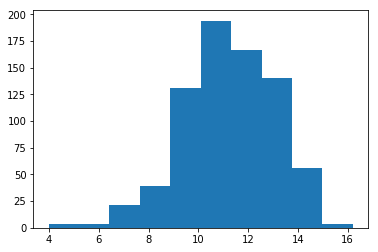

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(matched_df['st_j'])
plt.show()